#　参考
- https://github.com/wadayama/DU-Book/tree/main

In [1]:
import numpy as np
import jax

import matplotlib.pyplot as plt
import japanize_matplotlib
import math
import pandas as pd
from jax.example_libraries import optimizers

In [2]:
delta = 0.05
beta = 20.0

In [3]:
def rbf(x, beta):
    return np.exp(-beta*x**2)

In [4]:
xs = np.linspace(-1,2.5,100)

In [5]:
N = 50
df = pd.DataFrame()
df["x"] = xs
sample_columns = []
for i in range(N):
    colum = "sample_{}".format(i)
    df[colum] = rbf(xs - delta*(i-1)+0.5, beta)
    sample_columns.append(colum)

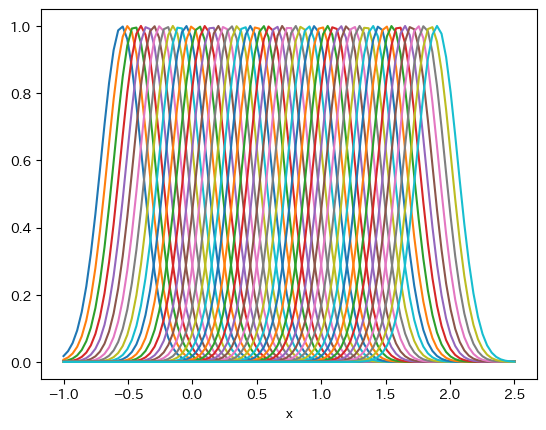

In [6]:
df.plot(x= "x", y = sample_columns, legend=False);

In [7]:
def rbf_func(x, theta):
    tmp_x = - delta * (np.arange(len(theta))) + x + 0.5
    rbfs = rbf(tmp_x, beta)
    return np.sum(theta * rbfs)

In [8]:
def Fit(T, N, theta):
    dx = T/N
    J = 0
    for i in range(N):
        u = rbf_func((i+1)*dx,  theta)
        # print(u)
        f = np.exp(-5*(i+1)*dx)*np.sin(5*(i+1)*dx)
        J += (u - f)**2
    return J

# 勾配降下法（手書き）版

In [9]:
# @jax.jit
def train(T, N, theta, lr):
    new_theta = theta
    for i in range(train_itr):
        gs = jax.grad(Fit, argnums=-1)(T, N, new_theta)
        new_theta -= lr * gs
        # print(new_theta, gs)
        print(Fit(T, N, new_theta))
    return new_theta

In [10]:
N = 100
T = 1.0
theta_train = np.ones(50)
train_itr = 500

new_theta = train(T, N, theta_train, 0.003)

2294.047
870.9848
338.923
138.58273
62.34261
32.734123
20.74108
15.461668
12.787417
11.163548
9.997196
9.058595
8.255521
7.5481944
6.9171305
6.35095
5.8417425
5.3832664
4.9702363
4.5980244
4.262512
3.960014
3.68722
3.4411516
3.2191355
3.0187614
2.8378634
2.6744928
2.526895
2.3934927
2.2728672
2.16374
2.0649607
1.9754981
1.8944194
1.8208876
1.7541502
1.6935287
1.6384138
1.588256
1.542563
1.5008888
1.4628353
1.4280416
1.396184
1.3669727
1.3401437
1.3154622
1.2927161
1.2717144
1.2522851
1.2342732
1.2175409
1.2019614
1.1874231
1.1738241
1.1610727
1.1490879
1.1377949
1.1271275
1.1170259
1.1074356
1.0983089
1.0896018
1.0812749
1.0732929
1.0656233
1.0582391
1.0511122
1.0442212
1.0375443
1.0310628
1.0247597
1.0186193
1.0126281
1.0067738
1.0010457
0.9954328
0.9899262
0.98451793
0.97920036
0.97396725
0.96881187
0.9637292
0.9587152
0.9537635
0.9488716
0.9440353
0.9392514
0.93451697
0.9298298
0.92518634
0.9205855
0.91602486
0.9115026
0.9070172
0.9025671
0.8981508
0.8937671
0.8894153
0.88509375
0.8

In [15]:
df = pd.DataFrame()
xs = np.linspace(0,1,100)

init = []
trained = []
exact = []
dx = T/N
for x in xs:
    init.append(rbf_func(x, theta_train))
    trained.append(rbf_func(x, new_theta))
    exact.append(np.exp(-5*x)*np.sin(5*x))
df["x"] = xs
df["init_RBF"] = init
df["trained_RBF"] = trained
df["trained_RBF"] = df["trained_RBF"].astype(float)
df["Exact"] = exact

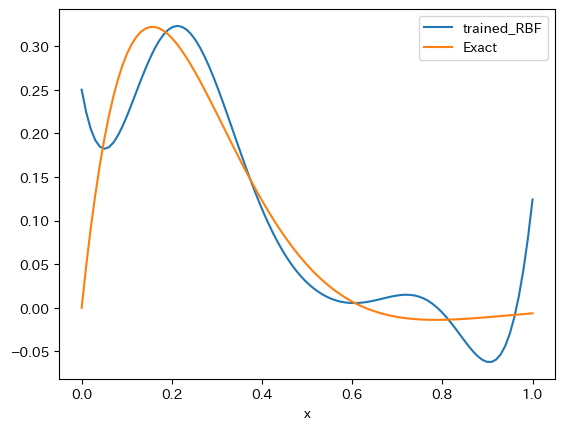

In [18]:
df.plot("x", ["trained_RBF", "Exact"]);#, "init_RBF"])

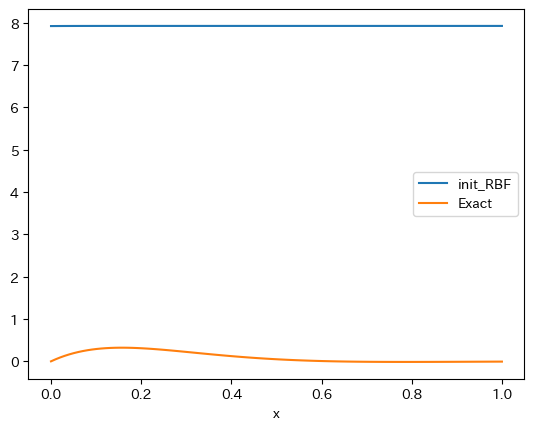

In [19]:
df.plot("x", ["init_RBF", "Exact"]);

# Adam版

In [20]:
@jax.jit
def step(step, opt_state):
    value, grads = jax.value_and_grad(Fit, argnums=-1)(T, N, get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

In [21]:
opt_init, opt_update, get_params = optimizers.adam(10)
opt_state = opt_init(theta_train)

train_itr = 250
for i in range(train_itr):
    value, opt_state = step(i, opt_state)
    print(value)

6126.3545
510349.25
34546.418
113235.336
287102.2
192537.36
37078.215
8156.719
93753.91
148753.66
108063.09
31679.43
113.80338
31423.182
74249.8
75786.73
38721.164
4706.133
4619.6016
29454.559
45728.7
35338.367
11769.799
14.513434
8646.791
23146.707
25140.795
13213.74
1537.5537
1786.2007
10575.906
15488.23
10665.336
2486.4224
238.59462
4856.382
9058.723
7302.7715
2191.636
23.51892
2514.202
5368.0312
4573.088
1417.9382
12.7855215
1578.4185
3311.4763
2675.5442
700.77545
46.282124
1180.5781
2092.5803
1424.7075
231.45317
131.5275
959.1457
1282.1356
634.5737
24.120749
243.41927
756.4313
695.9875
191.46466
13.301553
319.71927
519.5585
288.02478
15.853881
92.651276
306.9496
273.47284
62.518528
13.288158
153.35617
206.90155
85.991776
0.025115022
67.129845
137.48842
83.32502
4.9870276
26.33438
84.91933
67.88665
9.92646
9.463063
50.75754
50.223347
11.205671
3.2390704
30.314672
35.18256
9.877144
1.1545116
18.557016
23.917719
7.5195293
0.50810766
11.849226
15.992139
5.1413956
0.331141
7.9519787
10

In [22]:
df = pd.DataFrame()
xs = np.linspace(0,1,100)

init = []
trained = []
exact = []
dx = T/N
for x in xs:
    init.append(rbf_func(x, theta_train))
    trained.append(rbf_func(x, get_params(opt_state)))
    exact.append(np.exp(-5*x)*np.sin(5*x))
df["x"] = xs
df["init_RBF"] = init
df["trained_RBF"] = trained
df["trained_RBF"] = df["trained_RBF"].astype(float)
df["Exact"] = exact

<Axes: xlabel='x'>

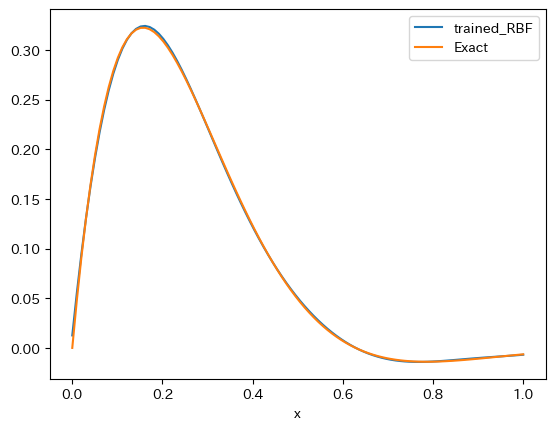

In [23]:
df.plot("x", ["trained_RBF", "Exact"])